# **Readme**  
**Author：WILD HORSE**
**数学建模小组成员：**  
队长 贾梓杏 SYSU-物理与天文学院2023级   
队员 夏解金鑫 SYSU-物理与天文学院2023级  
队员 刘张弛 SYSU-数学学院（珠海）2023级  
在代码部分不具体介绍某些模型的调用方法。毕竟现在是2025年了，`LLM`是个好东西。  
并且值得注意的是，大家如果希望复现我们的结果，需要按照文中的方法重新对数据进行处理。在仓库中仅给出了美赛官方给出的数据集

*PS:代码并非完全完整，在文章中也提到了，这里的代码仅有NLP部分。HOWEVER，这的确是超过90%的代码*。  

### **TaskOne** 有序逻辑回归  
数据处理部分

In [32]:
import pandas as pd

# 读取Excel文件
file_path = r'D:\FSS\MMM\MCM\20C\hair_dryer_clean_with_HR.xlsx'
df = pd.read_excel(file_path)

# 确保每一列的数据类型一致，并删除含有非预期类型的行或缺失值的行
def clean_column(df, column_name, dtype):
    # 检查是否为字符串类型（允许NaN）
    if dtype == str:
        df[column_name] = df[column_name].astype(str)
        return df[df[column_name].apply(lambda x: x.replace('.', '', 1).isdigit() is False)]
    
    # 尝试转换为指定类型，如果失败则删除该行
    try:
        df[column_name] = df[column_name].astype(dtype)
    except ValueError:
        df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    return df.dropna(subset=[column_name])

# 清洗每列数据
df = clean_column(df, 'star_rating', int)
df = clean_column(df, 'helpful_votes', int)
df = clean_column(df, 'review_body', str)
df = clean_column(df, 'verified_purchase', str)
df = clean_column(df, 'helpfulness_rating', int)
df = clean_column(df, 'compound', float)

# 计算评论长度并添加新列
df['length'] = df['review_body'].apply(len)

# 输出清理后的数据到新的Excel文件
output_file_path = r'D:\FSS\MMM\MCM\20C\hair_dryer_clean_with_HR_4_Reg.xlsx'
df.to_excel(output_file_path, index=False)

print(f"数据已成功清理并保存到 {output_file_path}")



数据已成功清理并保存到 D:\FSS\MMM\MCM\20C\hair_dryer_clean_with_HR_4_Reg.xlsx


**模型建立**  
此处是错误代码示例，mnlogit是用于“多项逻辑回归”，大家可以看看跑出来的结果是什么。

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind, chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 读取Excel文件
file_path = r'D:\FSS\MMM\MCM\20C\hair_dryer_clean_with_HR_4_Reg.xlsx'
data = pd.read_excel(file_path)

# 查看数据结构
print(data.head())

# 进行哑变量转换
data = pd.get_dummies(data, columns=['verified_purchase'], drop_first=True)

# 定义自变量和因变量
X = data[['star_rating', 'helpful_votes', 'length', 'compound', 'verified_purchase_Y']]
y = data['helpfulness_rating']

# 标准化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# 单因素检验：连续型自变量与因变量的关系 (t检验)
continuous_vars = ['star_rating', 'helpful_votes', 'length', 'compound']
for var in continuous_vars:
    group_0 = X_scaled_df[y == 0][var]
    group_1 = X_scaled_df[y == 1][var]
    group_2 = X_scaled_df[y == 2][var]
    group_3 = X_scaled_df[y == 3][var]
    group_4 = X_scaled_df[y == 4][var]
    
    stat, p_value = ttest_ind(group_0, group_1, equal_var=False)
    print(f'T-test for {var} between groups 0 and 1: Stat={stat}, P-value={p_value}')
    
    stat, p_value = ttest_ind(group_0, group_2, equal_var=False)
    print(f'T-test for {var} between groups 0 and 2: Stat={stat}, P-value={p_value}')
    
    stat, p_value = ttest_ind(group_0, group_3, equal_var=False)
    print(f'T-test for {var} between groups 0 and 3: Stat={stat}, P-value={p_value}')
    
    stat, p_value = ttest_ind(group_0, group_4, equal_var=False)
    print(f'T-test for {var} between groups 0 and 4: Stat={stat}, P-value={p_value}')

# 单因素检验：分类变量与因变量的关系 (卡方检验)
contingency_table = pd.crosstab(y, X['verified_purchase_Y'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f'Chi-square test for verified_purchase_Y: Chi2={chi2}, P-value={p_value}')

# 标准化因变量
y_mean = y.mean()
y_std = y.std()
y_scaled = (y - y_mean) / y_std

# 创建新的DataFrame用于建模
model_data = pd.concat([X_scaled_df, y], axis=1)

# 建立有序logistic模型
formula = 'helpfulness_rating ~ star_rating + helpful_votes + length + compound + verified_purchase_Y'
model = smf.mnlogit(formula=formula, data=model_data).fit()

# 输出回归结果
print(model.summary())



   star_rating  helpful_votes verified_purchase  compound  length  \
0            5              0                 Y    0.5994     119   
1            5              0                 Y    0.5411     136   
2            5              0                 Y    0.1406     171   
3            5              0                 N    0.6229     732   
4            4              0                 N    0.6956     560   

   helpfulness_rating  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
T-test for star_rating between groups 0 and 1: Stat=14.721791443331107, P-value=9.308509117645586e-48
T-test for star_rating between groups 0 and 2: Stat=12.657701964415104, P-value=3.069991397976054e-33
T-test for star_rating between groups 0 and 3: Stat=6.908530766893457, P-value=2.6135781361613004e-11
T-test for star_rating between groups 0 and 4: Stat=3.113990819477519, P-value=0.002543272385536654
T-test for helpful_votes between gr

d:\ANACONDA\envs\tf\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
d:\ANACONDA\envs\tf\lib\site-packages\statsmodels\discrete\discrete_model.py:3027: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
d:\ANACONDA\envs\tf\lib\site-packages\statsmodels\discrete\discrete_model.py:3028: RuntimeWarning: invalid value encountered in divide
  return eXB/eXB.sum(1)[:,None]


                          MNLogit Regression Results                          
Dep. Variable:     helpfulness_rating   No. Observations:                11464
Model:                        MNLogit   Df Residuals:                    11440
Method:                           MLE   Df Model:                           20
Date:                Wed, 22 Jan 2025   Pseudo R-squ.:                     nan
Time:                        10:55:22   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -10306.
Covariance Type:            nonrobust   LLR p-value:                       nan
helpfulness_rating=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                   nan        nan        nan        nan         nan         nan
star_rating                 nan        nan        nan        nan         nan         nan
helpful_vote

**模型建立**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind, chi2_contingency
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

# 读取Excel文件
file_path = r'D:\FSS\MMM\MCM\20C\hair_dryer_clean_with_HR_4_Reg.xlsx'
data = pd.read_excel(file_path)

# 查看数据结构
print(data.head())

# 进行哑变量转换
data = pd.get_dummies(data, columns=['verified_purchase'], drop_first=True)

# 定义自变量和因变量
X = data[['star_rating', 'helpful_votes', 'length', 'compound', 'verified_purchase_Y']]
y = data['helpfulness_rating']

# 标准化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# 单因素检验：连续型自变量与因变量的关系 (t检验)
continuous_vars = ['star_rating', 'helpful_votes', 'length', 'compound']
for var in continuous_vars:
    group_0 = X_scaled_df[y == 0][var]
    group_1 = X_scaled_df[y == 1][var]
    group_2 = X_scaled_df[y == 2][var]
    group_3 = X_scaled_df[y == 3][var]
    group_4 = X_scaled_df[y == 4][var]
    
    stat, p_value = ttest_ind(group_0, group_1, equal_var=False)
    print(f'T-test for {var} between groups 0 and 1: Stat={stat}, P-value={p_value}')
    
    stat, p_value = ttest_ind(group_0, group_2, equal_var=False)
    print(f'T-test for {var} between groups 0 and 2: Stat={stat}, P-value={p_value}')
    
    stat, p_value = ttest_ind(group_0, group_3, equal_var=False)
    print(f'T-test for {var} between groups 0 and 3: Stat={stat}, P-value={p_value}')
    
    stat, p_value = ttest_ind(group_0, group_4, equal_var=False)
    print(f'T-test for {var} between groups 0 and 4: Stat={stat}, P-value={p_value}')

# 单因素检验：分类变量与因变量的关系 (卡方检验)
contingency_table = pd.crosstab(y, X['verified_purchase_Y'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f'Chi-square test for verified_purchase_Y: Chi2={chi2}, P-value={p_value}')

# 使用OrderedModel进行有序逻辑回归
model = OrderedModel.from_formula('helpfulness_rating ~ star_rating + helpful_votes + length + compound + verified_purchase_Y', data=data, distr='logit')
result = model.fit(method='bfgs')

# 输出结果
print(result.summary())




   star_rating  helpful_votes verified_purchase  compound  length  \
0            5              0                 Y    0.5994     119   
1            5              0                 Y    0.5411     136   
2            5              0                 Y    0.1406     171   
3            5              0                 N    0.6229     732   
4            4              0                 N    0.6956     560   

   helpfulness_rating  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
T-test for star_rating between groups 0 and 1: Stat=14.721791443331107, P-value=9.308509117645586e-48
T-test for star_rating between groups 0 and 2: Stat=12.657701964415104, P-value=3.069991397976054e-33
T-test for star_rating between groups 0 and 3: Stat=6.908530766893457, P-value=2.6135781361613004e-11
T-test for star_rating between groups 0 and 4: Stat=3.113990819477519, P-value=0.002543272385536654
T-test for helpful_votes between gr

d:\ANACONDA\envs\tf\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 113
         Function evaluations: 122
         Gradient evaluations: 122
                             OrderedModel Results                             
Dep. Variable:     helpfulness_rating   Log-Likelihood:            -0.00011128
Model:                   OrderedModel   AIC:                             18.00
Method:            Maximum Likelihood   BIC:                             84.12
Date:                Wed, 22 Jan 2025                                         
Time:                        10:11:58                                         
No. Observations:               11464                                         
Df Residuals:                   11455                                         
Df Model:                           5                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
------------------

### **词频统计与TF-IDF计算**  
*词频统计不涉及Tokenizer*

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string

# 下载停用词
# nltk.download('stopwords')

# 读取Excel文件
file_path = r'D:\FSS\MMM\MCM\20C\hari_drier.xlsx'
df = pd.read_excel(file_path)

# 提取review_body列的数据
reviews = df['review_body'].astype(str).tolist()

# 文本预处理函数
def preprocess_text(text):
    # 转换为小写
    text = text.lower()
    # 去除标点符号
    text = text.translate(str.maketrans('', '', string.punctuation))
    # 分词
    words = text.split()
    # 去除停用词
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return words

# 预处理所有评论
all_words = []
for review in reviews:
    all_words.extend(preprocess_text(review))

# 统计词频
word_counts = Counter(all_words)

# 获取词频最高的前100个词
top_100_words = word_counts.most_common(200)

print("Top 200 Words and Their Frequencies:")
for word, freq in top_100_words:
    print(f"{word}: {freq}")




**TF-IDF计算**

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# 读取Excel文件
file_path = r'D:\FSS\MMM\MCM\20C\hari_drier.xlsx'
df = pd.read_excel(file_path)

# 提取review_body列的内容
reviews = df['review_body'].dropna()

# 初始化TF-IDF向量化器
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=50)

# 计算TF-IDF矩阵
tfidf_matrix = tfidf_vectorizer.fit_transform(reviews)

# 获取特征名称（词汇）
feature_names = tfidf_vectorizer.get_feature_names_out()

# 将TF-IDF矩阵转换为DataFrame以便查看
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# 计算每个词在整个数据集中的平均TF-IDF得分
mean_tfidf_scores = tfidf_df.mean(axis=0)

# 按照平均TF-IDF得分排序，获取前50个词
top_50_words = mean_tfidf_scores.sort_values(ascending=False).head(50)

print(top_50_words)





**ngram**

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# 读取Excel文件
file_path = r'D:\FSS\MMM\MCM\20C\hari_drier.xlsx'
df = pd.read_excel(file_path)

# 提取review_body列的内容
reviews = df['review_body'].dropna()

# 初始化TF-IDF向量化器
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=100)

# 计算TF-IDF矩阵
tfidf_matrix = tfidf_vectorizer.fit_transform(reviews)

# 获取特征名称（词汇和bigrams）
feature_names = tfidf_vectorizer.get_feature_names_out()

# 将TF-IDF矩阵转换为DataFrame以便查看
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# 计算每个词和bigram在整个数据集中的平均TF-IDF得分
mean_tfidf_scores = tfidf_df.mean(axis=0)

# 按照平均TF-IDF得分排序，获取前50个词和bigram
top_50_ngrams = mean_tfidf_scores.sort_values(ascending=False).head(50)

print(top_50_ngrams)





### **LDA**  
停用词及wordnet下载

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

**数据预处理及TF-IDF向量化**

In [1]:
import pandas as pd
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.coherencemodel import CoherenceModel
import gensim.downloader as api
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

# 1. 准备数据
file_path = r"D:\FSS\MMM\MCM\20C\hair_dryer_clean_with_HR.xlsx"
df = pd.read_excel(file_path)
texts = df['review_body'].astype(str).tolist()

# 2. 文本预处理
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # 替换多余的空白字符
    text = text.lower()  # 转换为小写
    text = re.sub(r'\W+', ' ', text)  # 只保留字母数字字符
    return text.split()  # 返回分词后的列表

texts = [preprocess_text(text) for text in texts]

# 3. TF-IDF向量化
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]  # 注意这里不再需要 split()
tfidf_model = TfidfModel(corpus)
corpus_tfidf = tfidf_model[corpus]




**LDA模型训练及结果查看**

In [2]:

lda_model = LdaMulticore(corpus=corpus_tfidf, id2word=dictionary, num_topics=3, passes=40, workers=3)


In [3]:
import re
# 提取每个主题下排名前十的关键词
def extract_top_words(topic, top_n=20):
    # 使用正则表达式找到所有关键词-权重对
    words = re.findall(r'"([^"]*)"', topic)
    # 只取前top_n个关键词
    return words[:top_n]

# 打印每个主题下排名前十的关键词
topics = lda_model.print_topics(num_words=20)
for topic_idx, topic in enumerate(topics):
    print(f"主题 {topic_idx+1}: {', '.join(extract_top_words(topic[1]))}")

主题 1: i, the, great, hair, it, a, to, dryer, is, my, good, and, for, very, this, works, of, br, one, was
主题 2: love, excellent, delivery, awesome, product, thanks, expectations, it, thank, none, available, met, bueno, exelente, exceeded, shipment, shipping, recomended, muy, condo
主题 3: she, loves, wife, perfect, gift, christmas, daughter, likes, her, excelente, mom, present, amazing, girlfriend, best, excelent, y, says, birthday, hello


**词云图绘制**

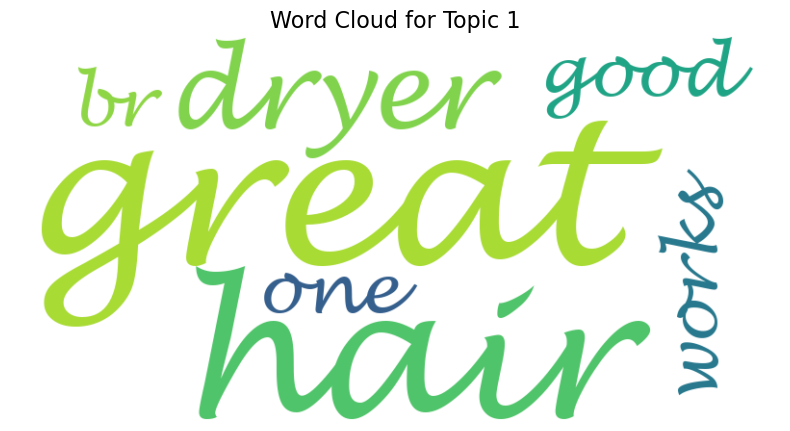

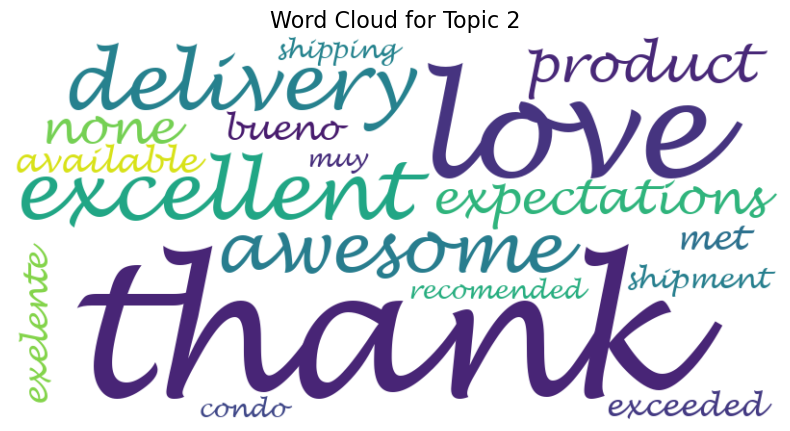

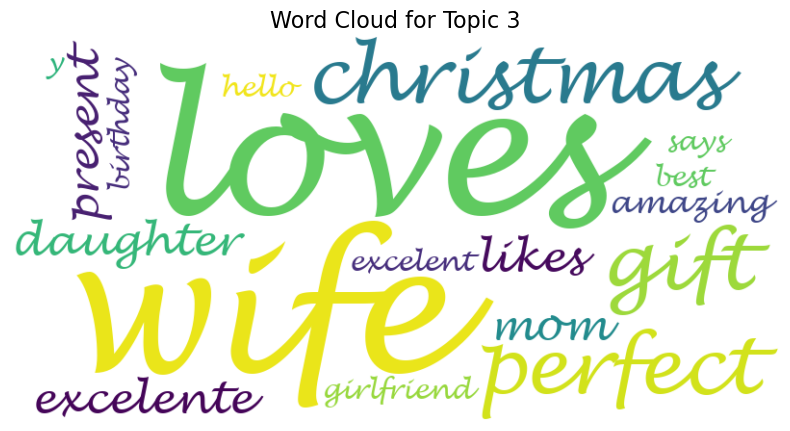

In [4]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os


# 提取每个主题下排名前十的关键词的函数
def extract_top_words(topic, top_n=20):
    words = re.findall(r'"([^"]*)"', topic)
    return words[:top_n]

# 创建词云图的函数
def create_wordcloud(words, font_path, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate(' '.join(words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

# 字体路径
font_path = r'c:\WINDOWS\Fonts\LHANDW.TTF'

# 验证字体文件是否存在
if not os.path.exists(font_path):
    print(f"Font file not found at {font_path}. Using default font.")
    font_path = None

# 绘制每个主题的词云图
for topic_idx, topic in enumerate(topics):
    top_words = extract_top_words(topic[1])
    title = f'Word Cloud for Topic {topic_idx + 1}'
    create_wordcloud(top_words, font_path, title)


### 情感倾向分析

**下载vader_lexicon资源**

In [ ]:
# 下载vader_lexicon资源
nltk.download('vader_lexicon')

**情感倾向分析（hair_drier）**

In [ ]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk


# 读取Excel文件
file_path = r"D:\FSS\MMM\MCM\20C\microwave.xlsx"
df = pd.read_excel(file_path)

# 初始化SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# 定义一个函数来处理空值和非字符串类型的数据
def clean_review(review):
    if isinstance(review, str):
        return review
    else:
        return ""

# 清理review_body列中的数据
df['cleaned_review'] = df['review_body'].apply(clean_review)

# 计算每个评论的情感分数
def get_compound_score(review):
    scores = sia.polarity_scores(review)
    return scores['compound']

# 创建新的列来存储compound得分
df['compound'] = df['cleaned_review'].apply(get_compound_score)

# 显示结果
print(df.head())

# 保存修改后的数据到新的Excel文件
output_file_path = r"Your file path"
df.to_excel(output_file_path, index=False)





**情感倾向分析（micro-wave & pacifier）**

In [ ]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# 下载vader_lexicon资源
nltk.download('vader_lexicon')

# 初始化SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# 定义一个函数来处理空值和非字符串类型的数据
def clean_review(review):
    if isinstance(review, str):
        return review
    else:
        return ""

# 定义一个函数来进行情感分析并保存结果
def process_reviews(file_path, output_file_path):
    # 读取Excel文件
    df = pd.read_excel(file_path)
    
    # 清理review_body列中的数据
    df['cleaned_review'] = df['review_body'].apply(clean_review)
    
    # 计算每个评论的情感分数
    def get_compound_score(review):
        scores = sia.polarity_scores(review)
        return scores['compound']
    
    # 创建新的列来存储compound得分
    df['compound'] = df['cleaned_review'].apply(get_compound_score)
    
    # 显示结果
    print(df.head())
    
    # 保存修改后的数据到新的Excel文件
    df.to_excel(output_file_path, index=False)

# 处理microwave.xlsx
process_reviews(r'D:\FSS\MMM\MCM\20C\microwave.xlsx', r'D:\FSS\MMM\MCM\20C\microwave_with_sentiment.xlsx')

# 处理pacifier.xlsx
process_reviews(r"D:\FSS\MMM\MCM\20C\pacifier_new.xlsx", r'D:\FSS\MMM\MCM\20C\pacifier_with_sentiment.xlsx')





### 统计星级与评论之间的关系

**hair_drier 与 Microwave**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# 读取Excel文件
file_path = r'D:\FSS\MMM\MCM\20C\pacifier_with_sentiment.xlsx'
df = pd.read_excel(file_path)

# 检查数据列是否存在
if 'review_body' in df.columns and 'star_rating' in df.columns and 'compound' in df.columns:
    # 计算每个星级的平均评论长度
    average_review_lengths = df.groupby('star_rating')['review_body'].apply(lambda x: x.str.len().mean()).sort_index()

    # 计算每个星级的平均compound值
    average_compounds = df.groupby('star_rating')['compound'].mean().sort_index()

    # 创建绘图数据
    plot_data = pd.DataFrame({
        'Star Rating': average_review_lengths.index,
        'Average Review Length': average_review_lengths.values,
        'Average Compound Score': average_compounds.values
    })

    # 设置Seaborn风格
    sns.set_theme(style="whitegrid")

    # 创建图形和子图
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 绘制左侧Y轴（平均评论长度）
    color = 'tab:blue'
    ax1.set_xlabel(r'$\mathbf{\mathrm{Star\ Rating}}$')
    ax1.set_ylabel(r'$\mathbf{\mathrm{Average\ Review\ Length}}$', color=color)
    ax1.bar(plot_data['Star Rating'], plot_data['Average Review Length'], color=color, alpha=0.7)
    ax1.tick_params(axis='y', labelcolor=color)

    # 创建第二个Y轴（共享X轴）
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel(r'$\mathbf{\mathrm{Average\ Emotion\ Score}}$', color=color)
    ax2.plot(plot_data['Star Rating'], plot_data['Average Compound Score'], color=color, marker='o')
    ax2.tick_params(axis='y', labelcolor=color)

    # 添加标题
    plt.title(r'$\mathbf{\mathrm{Average\ Review\ Length\ and\ Average\ Emotion\ Score\ by\ Star\ Rating}}$')

    # 显示图形
    plt.tight_layout()
    plt.show()
else:
    print("文件中缺少'review_body'、'star_rating'或'compound'列")





**相关系数计算**

In [ ]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr, kendalltau

# 读取Excel文件
file_path = r'D:\FSS\MMM\MCM\20C\pacifier_with_sentiment.xlsx'
df = pd.read_excel(file_path)

# 检查数据列是否存在
if 'review_body' in df.columns and 'star_rating' in df.columns and 'compound' in df.columns:
    # 检查 review_body 列的数据类型
    print("Data types of columns:")
    print(df.dtypes)
    
   
    # 处理 review_body 列中的缺失值和其他非字符串值
    df['review_body'] = df['review_body'].fillna('').astype(str)
    
    # 统一 star_rating 列的数据类型为整数，并过滤掉不在 1 到 5 范围内的值
    df['star_rating'] = pd.to_numeric(df['star_rating'], errors='coerce').dropna()
    df = df[df['star_rating'].isin([1, 2, 3, 4, 5])].copy()
    
    # 计算每个星级的平均评论长度
    average_review_lengths = df.groupby('star_rating')['review_body'].apply(lambda x: x.str.len().mean()).sort_index()
    
    # 计算每个星级的平均compound值
    average_compounds = df.groupby('star_rating')['compound'].mean().sort_index()
    
    # 创建绘图数据
    plot_data = pd.DataFrame({
        'Star Rating': average_review_lengths.index,
        'Average Review Length': average_review_lengths.values,
        'Average Compound Score': average_compounds.values
    })
    
    # 计算相关系数
    star_ratings = plot_data['Star Rating']
    avg_review_lengths = plot_data['Average Review Length']
    avg_compound_scores = plot_data['Average Compound Score']
    
    # 皮尔森相关系数
    pearson_corr_avg_review_length, _ = pearsonr(star_ratings, avg_review_lengths)
    pearson_corr_avg_compound_score, _ = pearsonr(star_ratings, avg_compound_scores)
    
    # 斯皮尔曼相关系数
    spearman_corr_avg_review_length, _ = spearmanr(star_ratings, avg_review_lengths)
    spearman_corr_avg_compound_score, _ = spearmanr(star_ratings, avg_compound_scores)
    
    # 肯德尔相关系数
    kendall_corr_avg_review_length, _ = kendalltau(star_ratings, avg_review_lengths)
    kendall_corr_avg_compound_score, _ = kendalltau(star_ratings, avg_compound_scores)
    
    # 输出结果
    print(f"\n皮尔森相关系数 - 平均评论长度: {pearson_corr_avg_review_length}")
    print(f"皮尔森相关系数 - 平均Compound得分: {pearson_corr_avg_compound_score}")
    print(f"斯皮尔曼相关系数 - 平均评论长度: {spearman_corr_avg_review_length}")
    print(f"斯皮尔曼相关系数 - 平均Compound得分: {spearman_corr_avg_compound_score}")
    print(f"肯德尔相关系数 - 平均评论长度: {kendall_corr_avg_review_length}")
    print(f"肯德尔相关系数 - 平均Compound得分: {kendall_corr_avg_compound_score}")
else:
    print("文件中缺少'review_body'、'star_rating'或'compound'列")





*PS：Pacifier数据存在一些问题，需要特殊处理*

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取Excel文件
file_path = r'D:\FSS\MMM\MCM\20C\pacifier_with_sentiment.xlsx'
df = pd.read_excel(file_path)

# 检查数据列是否存在
if 'review_body' in df.columns and 'star_rating' in df.columns and 'compound' in df.columns:
    # 处理 review_body 列中的缺失值和其他非字符串值
    df['review_body'] = df['review_body'].fillna('').astype(str)

    # 统一 star_rating 列的数据类型为整数
    df['star_rating'] = pd.to_numeric(df['star_rating'], errors='coerce').dropna()

    # 数据类型转换时会出现star_rating大于5的情况（ASCII码），需要过滤掉不在 1 到 5 范围内的值
    df = df[df['star_rating'].isin([1, 2, 3, 4, 5])].copy()

    # 计算每个星级的平均评论长度
    average_review_lengths = df.groupby('star_rating')['review_body'].apply(lambda x: x.str.len().mean()).sort_index()

    # 计算每个星级的平均compound值
    average_compounds = df.groupby('star_rating')['compound'].mean().sort_index()

    # 创建绘图数据
    plot_data = pd.DataFrame({
        'Star Rating': average_review_lengths.index,
        'Average Review Length': average_review_lengths.values,
        'Average Compound Score': average_compounds.values
    })

    # 设置Seaborn风格
    sns.set_theme(style="whitegrid")

    # 创建图形和子图
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 绘制左侧Y轴（平均评论长度）
    color = 'tab:blue'
    ax1.set_xlabel(r'$\mathbf{\mathrm{Star\ Rating}}$')
    ax1.set_ylabel(r'$\mathbf{\mathrm{Average\ Review\ Length}}$', color=color)
    ax1.bar(plot_data['Star Rating'], plot_data['Average Review Length'], color=color, alpha=0.7)
    ax1.tick_params(axis='y', labelcolor=color)

    # 创建第二个Y轴（共享X轴）
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel(r'$\mathbf{\mathrm{Average\ Emotion\ Score}}$', color=color)
    ax2.plot(plot_data['Star Rating'], plot_data['Average Compound Score'], color=color, marker='o')
    ax2.tick_params(axis='y', labelcolor=color)

    # 添加标题
    plt.title(r'$\mathbf{\mathrm{Average\ Review\ Length\ and\ Average\ Emotion\ Score\ by\ Star\ Rating}}$')

    # 显示图形
    plt.tight_layout()
    plt.show()
else:
    print("文件中缺少'review_body'、'star_rating'或'compound'列")




**相关系数计算**

In [ ]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr, kendalltau

# 读取Excel文件
file_path = r'D:\FSS\MMM\MCM\20C\pacifier_with_sentiment.xlsx'
df = pd.read_excel(file_path)

# 检查数据列是否存在
if 'review_body' in df.columns and 'star_rating' in df.columns and 'compound' in df.columns:
    # 计算每个星级的平均评论长度
    average_review_lengths = df.groupby('star_rating')['review_body'].apply(lambda x: x.str.len().mean()).sort_index()

    # 计算每个星级的平均compound值
    average_compounds = df.groupby('star_rating')['compound'].mean().sort_index()

    # 创建绘图数据
    plot_data = pd.DataFrame({
        'Star Rating': average_review_lengths.index,
        'Average Review Length': average_review_lengths.values,
        'Average Compound Score': average_compounds.values
    })

    # 计算相关系数
    star_ratings = plot_data['Star Rating']
    avg_review_lengths = plot_data['Average Review Length']
    avg_compound_scores = plot_data['Average Compound Score']

    # 皮尔森相关系数
    pearson_corr_avg_review_length, _ = pearsonr(star_ratings, avg_review_lengths)
    pearson_corr_avg_compound_score, _ = pearsonr(star_ratings, avg_compound_scores)

    # 斯皮尔曼相关系数
    spearman_corr_avg_review_length, _ = spearmanr(star_ratings, avg_review_lengths)
    spearman_corr_avg_compound_score, _ = spearmanr(star_ratings, avg_compound_scores)

    # 肯德尔相关系数
    kendall_corr_avg_review_length, _ = kendalltau(star_ratings, avg_review_lengths)
    kendall_corr_avg_compound_score, _ = kendalltau(star_ratings, avg_compound_scores)

    # 输出结果
    print(f"皮尔森相关系数 - 平均评论长度: {pearson_corr_avg_review_length}")
    print(f"皮尔森相关系数 - 平均Compound得分: {pearson_corr_avg_compound_score}")
    print(f"斯皮尔曼相关系数 - 平均评论长度: {spearman_corr_avg_review_length}")
    print(f"斯皮尔曼相关系数 - 平均Compound得分: {spearman_corr_avg_compound_score}")
    print(f"肯德尔相关系数 - 平均评论长度: {kendall_corr_avg_review_length}")
    print(f"肯德尔相关系数 - 平均Compound得分: {kendall_corr_avg_compound_score}")
else:
    print("文件中缺少'review_body'、'star_rating'或'compound'列")





**词云图绘制**

In [ ]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 设置使用LaTeX字体
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"]
})

# 读取Excel文件
file_path = r'D:\FSS\MMM\MCM\20C\hari_drier.xlsx'
df = pd.read_excel(file_path)

# 检查数据
print(df.head())

# 根据星级分组
ratings = df['star_rating'].unique()
for rating in ratings:
    # 获取特定星级的评论，并去掉空值
    reviews = df[df['star_rating'] == rating]['review_body'].dropna()
    
    if len(reviews) == 0:
        print(f"No valid reviews for star rating {rating}")
        continue
    
    # 初始化TfidfVectorizer
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(reviews)
    
    # 计算每个词汇的平均TF-IDF值
    sum_tfidf = tfidf_matrix.sum(axis=0)
    avg_tfidf = {feature: sum_tfidf[0, idx] for feature, idx in vectorizer.vocabulary_.items()}
    sorted_avg_tfidf = sorted(avg_tfidf.items(), key=lambda x: x[1], reverse=True)
    
    # 创建词频字典用于词云，从第5名开始
    word_freq = dict(sorted_avg_tfidf[4:104])  # 取第5到第104个高频词汇
    
    # 字体路径
    font_path = r'c:\WINDOWS\Fonts\LHANDW.TTF'
    
    # 验证字体文件是否存在
    if not os.path.exists(font_path):
        print(f"Font file not found at {font_path}. Using default font.")
        font_path = None
    
    # 绘制词云
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate_from_frequencies(word_freq)
    
    # 显示词云
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Star Rating {rating}', fontsize=16)
    plt.axis('off')
    plt.show()



